# Log odds ratio prediction

Predict binary relation between DrugProt entities based on log odds ratio. First determine unique entities based on the name from the entity file. Later improve on it by using database to determine unique entities.

In [1]:
import pandas as pd
from tqdm import tqdm

processed_path = "./data/drugprot/"
raw_path = "./raw_data/drugprot-training-development-test-background/drugprot-gs-training-development/training/"
ent_file = raw_path + "drugprot_training_entities.tsv"
# pre-processed data
dev_file = processed_path + "dev.tsv"
train_file = processed_path + "train.tsv"
test_file = processed_path + "test.tsv"

# train data
df = pd.read_table(train_file, header=None, dtype=str, names=["id", "text", "relation"])
df

,id,text,relation
0,17512723.T12.T3,"@GENE$, a @CHEMICAL$ dehydrogenase causing Leb...",false
1,17512723.T13.T3,"RDH12, a @CHEM-GENE$ causing Leber's congenita...",false
2,17512723.T2.T4,Three @CHEMICAL$ dehydrogenases (RDHs) were te...,false
3,17512723.T2.T8,Three @CHEMICAL$ dehydrogenases (@GENE$) were ...,false
4,17512723.T10.T2,Three @CHEM-GENE$ (RDHs) were tested for stero...,false
...,...,...,...
64724,17315049.T10.T12,"Like other DPP-4 inhibitors, @CHEMICAL$ reduce...",false
64725,17315049.T10.T13,"Like other DPP-4 inhibitors, @CHEMICAL$ reduce...",false
64726,17315049.T28.T10,"Like other @GENE$ inhibitors, @CHEMICAL$ reduc...",INHIBITOR
64727,17315049.T10.T29,"Like other DPP-4 inhibitors, @CHEMICAL$ reduce...",INDIRECT-DOWNREGULATOR


In [2]:
# entity data
df_ent = pd.read_table(
    ent_file,
    header=None,
    dtype=str,
    names=["PMID", "id", "type", "start", "end", "text"],
)
df_ent

,PMID,id,type,start,end,text
0,11808879,T1,CHEMICAL,1165,1174,diazoxide
1,11808879,T2,CHEMICAL,1450,1459,Diazoxide
2,11808879,T3,CHEMICAL,1901,1910,diazoxide
3,11808879,T4,CHEMICAL,1993,2002,glutamate
4,11808879,T5,CHEMICAL,917,924,glucose
...,...,...,...,...,...,...
89524,17653133,T21,GENE-N,572,580,protease
89525,17653133,T22,GENE-N,744,752,Arginase
89526,17653133,T23,GENE-N,756,777,nitric oxide synthase
89527,17653133,T24,GENE-Y,897,901,DDAH


## All entity combinations with binary relation

In [3]:
# df_test = df.iloc[:20, :]

In [5]:
import pickle

def update_rel_dict(rel_dict, ent1, ent2, rel):
    """create dict of all occuring relations between different entities"""
    # check that both entity texts are strings
    if (not isinstance(ent1, str)) or (not isinstance(ent2, str)):
        print(f"Entity not a string: {ent1}, {ent2}")
        return
    if ent1 < ent2:
        e1 = ent1
        e2 = ent2
    elif ent2 < ent1:
        e1 = ent2
        e2 = ent1
    else:
        print(f"Neither entity string is smaller: {ent1}, {ent2}")
        return
    if e1 in rel_dict:
        if e2 in rel_dict[e1]:
            if rel not in rel_dict[e1][e2]:
                rel_dict[e1][e2].append(rel)
        else:
            rel_dict[e1][e2] = [rel]
    else:
        rel_dict[e1] = {}
        rel_dict[e1][e2] = [rel]

def update_co_count(co_count, ent1, ent2):
    """count number of cooccurences of two entities without using labels"""
    # check that both entity texts are strings
    if (not isinstance(ent1, str)) or (not isinstance(ent2, str)):
        print(f"Entity not a string: {ent1}, {ent2}")
        return
    if ent1 < ent2:
        e1 = ent1
        e2 = ent2
    elif ent2 < ent1:
        e1 = ent2
        e2 = ent1
    else:
        print(f"Neither entity string is smaller: {ent1}, {ent2}")
        return
    if e1 in co_count:
        if e2 in co_count[e1]:
            co_count[e1][e2] += 1
        else:
            co_count[e1][e2] = 1
    else:
        co_count[e1] = {}
        co_count[e1][e2] = 1

rel_dict = {}
unsup_co_count = {}
for idx, text, relation in tqdm(df.itertuples(index=False)):
    PMID, e1, e2 = idx.split(".")
    # entity IDs should be different
    if e1 == e2:
        continue
    df_pmid = df_ent.loc[df_ent["PMID"] == PMID, :]
    ent1 = df_pmid.loc[df_pmid["id"] == e1, :]["text"].values[0]
    ent2 = df_pmid.loc[df_pmid["id"] == e2, :]["text"].values[0]
    # entity text should be different
    if ent1 == ent2:
        continue
    if relation != 'false':
        rel = 'related'
    else:
        rel = 'false'
    update_rel_dict(rel_dict, ent1, ent2, rel)
    update_co_count(unsup_co_count, ent1, ent2)
    # save dict
    pickle.dump(rel_dict, open("bin_rel_dict.p", "wb"))
    pickle.dump(unsup_co_count, open("unsup_co_dict.p", "wb"))

16696it [02:49, 80.95it/s]

Entity not a string: histamine H1-receptor, nan
Entity not a string: histamine H1-receptor, nan
Entity not a string: nan, alpha-adrenoceptors
Entity not a string: nan, alpha-adrenoceptors
Entity not a string: histamine H1-receptor, nan
Entity not a string: histamine H1-receptor, nan
Entity not a string: H1, nan
Entity not a string: H1, nan
Entity not a string: histamine H1-receptor, nan
Entity not a string: histamine H1-receptor, nan


16713it [02:49, 78.21it/s]

Entity not a string: H1, nan
Entity not a string: H1, nan


24349it [04:42, 61.41it/s]

Entity not a string: nan, NNMT
Entity not a string: nan, NNMT
Entity not a string: NNMT, nan
Entity not a string: NNMT, nan


27139it [05:29, 59.27it/s]

Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1B/D, nan
Entity not a string: 5-HT1B/D, nan


41886it [10:09, 47.46it/s]

Entity not a string: alpha 1 A-adrenoceptor, nan
Entity not a string: alpha 1 A-adrenoceptor, nan
Entity not a string: nan, alpha 1-adrenoceptor
Entity not a string: nan, alpha 1-adrenoceptor
Entity not a string: alpha 1A adrenoceptors, nan
Entity not a string: alpha 1A adrenoceptors, nan


41901it [10:09, 47.26it/s]

Entity not a string: nan, alpha 1-adrenoceptor
Entity not a string: nan, alpha 1-adrenoceptor


57694it [16:32, 37.20it/s]

Entity not a string: nan, alpha-2 AR
Entity not a string: nan, alpha-2 AR
Entity not a string: alpha-2CDel AR, nan
Entity not a string: alpha-2CDel AR, nan


64729it [19:48, 54.45it/s]


## Unsupervised log odds ratio prediction

In [5]:
len(unsup_co_count)

11342

In [3]:
import pickle

ent_count = pickle.load(open("ent_count_dict.p", "rb"))
# unsup_co_count = pickle.load(open("unsup_co_dict.p", "rb"))
# rel_dict = pickle.load(open("bin_rel_dict.p", "rb"))

In [4]:
def unsup_cooc(unsup_co_dict, ent1, ent2, co_val):
    unsup_cooc[ent1][ent2] = co_val
    
from math import log2

n = len(df)
unsup_co_dict = {}
unsup_co_list = []
for e1 in tqdm(unsup_co_count):
    unsup_co_dict[e1] = {}
    for e2 in unsup_co_count[e1]:
        unsup_co_dict[e1][e2] = log2((n * unsup_co_count[e1][e2]) / (ent_count[e1] * ent_count[e2]))
        unsup_co_list.append(unsup_co_dict[e1][e2])

NameError: name 'unsup_co_count' is not defined

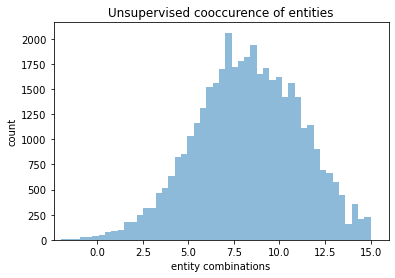

In [9]:
import numpy as np
import math
import matplotlib.pyplot as plt

clf = unsup_co_list
bins = np.linspace(math.ceil(min(clf)), 
                   math.floor(max(clf)),
                   50) # fixed number of bins

plt.xlim([min(clf), max(clf)])

plt.hist(unsup_co_list, bins=bins, alpha=0.5)
plt.title('Unsupervised cooccurence of entities')
plt.xlabel('entity combinations')
plt.ylabel('count')

plt.show()

In [10]:
def binary_class_ratios(unsup_co_dict, bin_rel_dict, unambiguos=False):
    """returns two lists with log odds ratios, one for related entities and on for unrelated ('false')"""
    rel_list = []; false_list = []; label_list = []
    for e1 in tqdm(unsup_co_count):
        unsup_co_dict[e1] = {}
        for e2 in unsup_co_count[e1]:
            log_odds = log2((n * unsup_co_count[e1][e2]) / (ent_count[e1] * ent_count[e2]))
            if unambiguos:
                if len(bin_rel_dict[e1][e2]) != 1:
                    continue
            if 'false' in bin_rel_dict[e1][e2]:
                false_list.append(log_odds)
                label_list.append(False)
            if 'related' in bin_rel_dict[e1][e2]:
                rel_list.append(log_odds)
                label_list.append(True)
    return rel_list, false_list

reulated, unrelated = binary_class_ratios(unsup_co_dict, rel_dict, False)

100%|█████████████████████████████████| 11342/11342 [00:00<00:00, 183436.92it/s]

[12.174769673304432, 8.827306486309931, 14.39716209464088, 10.075233999753518, 5.0979540762536, 11.660196500474674, 12.660196500474674, 7.9597567823335815, 4.693258521196216, 8.419882171140964]
[8.34187965913969, 10.367414751246828, 7.7824522505256715, 7.02502255379975, 10.149234581197295, 9.564272080476139, 6.564272080476138, 6.242343985588776, 9.149234581197295, 7.827306486309932]


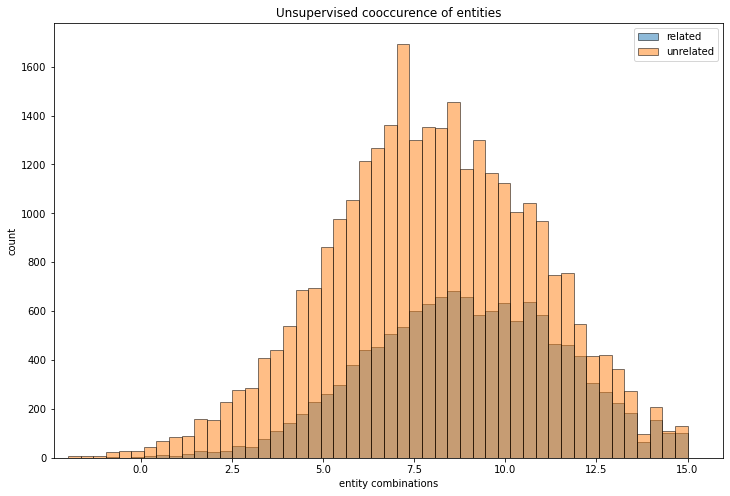

In [11]:
bins = np.linspace(math.ceil(min([min(related), min(unrelated)])), 
                   math.floor(max([max(related), max(unrelated)])),
                   50) # fixed number of bins

fig = plt.figure(figsize=(12, 8))
plt.xlim([min([min(related), min(unrelated)]), max([max(related), max(unrelated)])])

plt.hist(related, bins=bins, alpha=0.5, label='related', edgecolor = "black")
plt.hist(unrelated, bins=bins, alpha=0.5, label='unrelated', edgecolor = "black")
plt.title('Unsupervised cooccurence of entities')
plt.xlabel('entity combinations')
plt.ylabel('count')
plt.legend()
plt.show()

## Prediction on train data

In [ ]:
def predict(co_dict, threshold):
    pred_dict = {}; pred_list = []
    for e1 in co_dict:
        pred_dict[e1] = {}
        for e2 in co_dict[e1]:
            if co_dict[e1][e2] >= threshold:
                pred_dict[e1][e2] = True
                pred_list.append(True)
            else:
                pred_dict[e1][e2] = False
                pred_list.append(False)
    return pred_dict, pred_list

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
p, r, f, s = precision_recall_fscore_support(label, pred)

thresholds = np.linspace(math.ceil(min([min(related), min(unrelated)])), 
                   math.floor(max([max(related), max(unrelated)])),
                   50) # fixed number of thresholds
eval_dict = {}

for t in thresholds:
    pred_dict, pred_list = predict(unsup_co_dict, t)
    p, r, f, _ = precision_recall_fscore_support(label_list, pred_list)
    eval_dict[t] = (p, r, f)

## Kernel Density Estimate

In [12]:
from sklearn.neighbors import KernelDensity
import numpy as np

related_array = np.array(related)
related_array = related_array.reshape(-1, 1)
unrelated_array = np.array(unrelated)
unrelated_array = unrelated_array.reshape(-1, 1)

kde_rel = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(related_array)
kde_un = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(unrelated_array)

[]

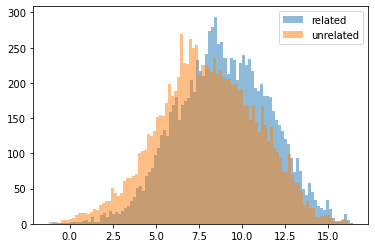

In [13]:
samples_rel = kde_rel.sample(10000)
samples_un = kde_un.sample(10000)

plt.hist(samples_rel, bins = 100, label='related', alpha=0.5)
plt.hist(samples_un, bins=100, label='unrelated', alpha=0.5)
plt.legend()
plt.plot()

In [21]:
# prediction
def predict_kde(kde_rel, kde_un, data):
    score_rel = kde_rel.score_samples(data)
    score_un = kde_un.score_samples(data)
    prediction = score_rel > score_un
    return prediction

pred_rel = predict_kde(kde_rel, kde_un, related_array)
pred_un = predict_kde(kde_rel, kde_un, unrelated_array)

[-2.49821186 -1.97200383 -4.01056971 ... -2.60179603 -2.60179603
 -2.60179603]
[-3.01125392 -2.08510652 -4.72053307 ... -3.1043664  -3.1043664
 -3.1043664 ]
[-1.93859157 -2.04627146 -2.02473074 ... -2.60179603 -2.60179603
 -2.37265204]
[-2.03049421 -2.30859886 -2.06221919 ... -3.1043664  -3.1043664
 -2.16467279]


In [26]:
print(sum(pred_rel) / len(pred_rel))
print(sum(pred_un) / len(pred_un))

0.681206806866315
0.5438812527040969


# Prediction on dev data

In [41]:
ent_file = "./raw_data/drugprot-training-development-test-background/drugprot-gs-training-development/development/drugprot_development_entities.tsv"

# dev data
df = pd.read_table(dev_file, header=None, dtype=str, names=["id", "text", "relation"])
# entity data
df_ent = pd.read_table(
    ent_file,
    header=None,
    dtype=str,
    names=["PMID", "id", "type", "start", "end", "text"],
)

In [44]:
import pickle

def update_ent_count(ent_count, ent):
    """count how many times an entity is mentioned in total"""
    if ent in ent_count:
        ent_count[ent] += 1
    else:
        ent_count[ent] = 1

def update_co_count(co_count, ent1, ent2):
    """count number of cooccurences of two entities without using labels"""
    # check that both entity texts are strings
    if (not isinstance(ent1, str)) or (not isinstance(ent2, str)):
        print(f"Entity not a string: {ent1}, {ent2}")
        return
    if ent1 < ent2:
        e1 = ent1
        e2 = ent2
    elif ent2 < ent1:
        e1 = ent2
        e2 = ent1
    else:
        print(f"Neither entity string is smaller: {ent1}, {ent2}")
        return
    if e1 in co_count:
        if e2 in co_count[e1]:
            co_count[e1][e2] += 1
        else:
            co_count[e1][e2] = 1
    else:
        co_count[e1] = {}
        co_count[e1][e2] = 1

ent_count_dict = {}
unsup_co_count = {}
for idx, text, relation in tqdm(df.itertuples(index=False)):
    PMID, e1, e2 = idx.split(".")
    # entity IDs should be different
    if e1 == e2:
        continue
    df_pmid = df_ent.loc[df_ent["PMID"] == PMID, :]
    ent1 = df_pmid.loc[df_pmid["id"] == e1, :]["text"].values[0]
    ent2 = df_pmid.loc[df_pmid["id"] == e2, :]["text"].values[0]
    # entity text should be different
    if ent1 == ent2:
        continue
    update_ent_count(ent_count_dict, ent1)
    update_ent_count(ent_count_dict, ent2)
    update_co_count(unsup_co_count, ent1, ent2)
    # save dict
    pickle.dump(ent_count_dict, open("dev_ent_dict.p", "wb"))
    pickle.dump(unsup_co_count, open("dev_co_dict.p", "wb"))

7976it [00:26, 251.58it/s]

Entity not a string: alpha 1-adrenoceptor, nan


11754it [00:43, 214.94it/s]

Entity not a string: nan, noradrenaline transporter
Entity not a string: nan, NAT


13445it [00:51, 261.08it/s]


In [54]:
# prediction
def predict_kde(kde_rel, kde_un, data):
    data = np.array([data])
    data = data.reshape(-1, 1)
    # data.reshape()
    score_rel = kde_rel.score_samples(data)
    score_un = kde_un.score_samples(data)
    prediction = score_rel > score_un
    return prediction[0]

def predict_relation(kde_rel, kde_un, data_dict, ent_count):
    """Predict relation class given two kdes and a dictionary with log odds ratios"""
    pred = []; label = []
    for idx, text, relation in tqdm(df.itertuples(index=False)):
        PMID, e1, e2 = idx.split(".")
        # entity IDs should be different
        if e1 == e2:
            continue
        df_pmid = df_ent.loc[df_ent["PMID"] == PMID, :]
        ent1 = df_pmid.loc[df_pmid["id"] == e1, :]["text"].values[0]
        ent2 = df_pmid.loc[df_pmid["id"] == e2, :]["text"].values[0]
        # entity text should be different
        if ent1 == ent2:
            continue
        if ent1 in data_dict:
            if ent2 in data_dict[ent1]:
                log_odds = log2((n * data_dict[ent1][ent2]) / (ent_count[ent1] * ent_count[ent2]))
                pred.append(predict_kde(kde_rel, kde_un, log_odds))
                label.append(True if relation != 'false' else False)
    return pred, label

n = len(df)
pred, label = predict_relation(kde_rel, kde_un, unsup_co_count, ent_count_dict)

13445it [00:42, 314.03it/s]

[True, True, True, True, True, True, False, False, False, False, True, False, True, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, False, True, False, False, True, False, False, True, False, True, False, False, True, True, True, False, True, True, False, False, False, False, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, Tr

In [56]:
from sklearn.metrics import precision_recall_fscore_support
p, r, f, s = precision_recall_fscore_support(label, pred)

In [57]:
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F1-score: {f}")
print(f"Support: {s}")

Precision: [0.78152394 0.37073316]
Recall: [0.52230735 0.65840801]
F1-score: [0.62614803 0.47436384]
Support: [4438 1897]


## Supervised log odds ratio prediction

In [4]:
def update_ent_count(ent_count, ent):
    """count how many times an entity is mentioned in total"""
    if ent in ent_count:
        ent_count[ent] += 1
    else:
        ent_count[ent] = 1


def update_co_count(co_count, ent1, ent2):
    """count number of cooccurences of two entities, but only if they are related"""
    # check that both entity texts are strings
    if (not isinstance(ent1, str)) or (not isinstance(ent2, str)):
        print(f"Entity not a string: {ent1}, {ent2}")
        return
    if ent1 < ent2:
        e1 = ent1
        e2 = ent2
    elif ent2 < ent1:
        e1 = ent2
        e2 = ent1
    else:
        print(f"Neither entity string is smaller: {ent1}, {ent2}")
        return
    if e1 in co_count:
        if e2 in co_count[e1]:
            co_count[e1][e2] += 1
        else:
            co_count[e1][e2] = 1
    else:
        co_count[e1] = {}
        co_count[e1][e2] = 1

ent_count = {}
co_count = {}
for idx, text, relation in tqdm(df.itertuples(index=False)):
    PMID, e1, e2 = idx.split(".")
    # entity IDs should be different
    if e1 == e2:
        print(f"Entity IDs are equal: {e1}, {e2}")
        continue
    df_pmid = df_ent.loc[df_ent["PMID"] == PMID, :]
    ent1 = df_pmid.loc[df_pmid["id"] == e1, :]["text"].values[0]
    ent2 = df_pmid.loc[df_pmid["id"] == e2, :]["text"].values[0]
    # ToDo: decide if texts should be different
    # entity text should be different (?)
    if ent1 == ent2:
        print(f"Entity texts are equal: {ent1}, {ent2}, relation: {relation}")
        continue
    update_ent_count(ent_count, ent1)
    update_ent_count(ent_count, ent2)
    if relation != 'false':
        update_co_count(co_count, ent1, ent2)

292it [00:01, 164.15it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


326it [00:01, 161.93it/s]

Entity texts are equal: Ang II, Ang II, relation: false


428it [00:02, 164.12it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


2755it [00:16, 166.61it/s]

Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: AII, AII, relation: false


5783it [00:35, 164.54it/s]

Entity texts are equal: Cys-Pro-Tyr-Cys, Cys-Pro-Tyr-Cys, relation: false
Entity texts are equal: Cys-Ser-Tyr-Cys, Cys-Ser-Tyr-Cys, relation: false


7524it [00:45, 165.68it/s]

Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: AT1, AT1, relation: false
Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: AT1, AT1, relation: false
Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


9140it [00:55, 160.45it/s]

Entity texts are equal: DPP-4, DPP-4, relation: false


9226it [00:56, 161.32it/s]

Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false


9260it [00:56, 160.89it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


9310it [00:56, 158.08it/s]

Entity texts are equal: Ang I, Ang I, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


10153it [01:01, 168.00it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: arginine-vasopressin, arginine-vasopressin, relation: false


10986it [01:06, 165.21it/s]

Entity texts are equal: NMDA, NMDA, relation: false


11573it [01:10, 171.25it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GH-releasing hormone, GH-releasing hormone, relation: false
Entity texts are equal: TRH, TRH, relation: false


12322it [01:14, 166.61it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false


13058it [01:19, 162.65it/s]

Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false


13126it [01:19, 163.18it/s]

Entity texts are equal: VanB, VanB, relation: false


13212it [01:20, 163.10it/s]

Entity texts are equal: GnRH, GnRH, relation: false


13454it [01:21, 164.33it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


13505it [01:22, 163.53it/s]

Entity texts are equal: dynorphin A, dynorphin A, relation: false
Entity texts are equal: dynorphin A, dynorphin A, relation: false


14077it [01:25, 164.59it/s]

Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false


15977it [01:37, 171.87it/s]

Entity texts are equal: substance P, substance P, relation: false
Entity texts are equal: SP, SP, relation: false
Entity texts are equal: SP, SP, relation: false


17918it [01:48, 169.58it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


18335it [01:51, 169.24it/s]

Entity texts are equal: n-formyl-met-leu-phe, n-formyl-met-leu-phe, relation: false


18606it [01:53, 157.58it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


19644it [01:59, 162.99it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


20486it [02:04, 164.63it/s]

Entity texts are equal: 17 beta-EDH, 17 beta-EDH, relation: false


21119it [02:08, 164.73it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Arginine vasopressin, Arginine vasopressin, relation: false


21497it [02:10, 165.82it/s]

Entity texts are equal: mTOR, mTOR, relation: false


21617it [02:11, 164.88it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


22084it [02:14, 165.01it/s]

Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false


22151it [02:14, 119.43it/s]

Entity texts are equal: Angiotensin II, Angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


23235it [02:22, 146.80it/s]

Entity texts are equal: DP, DP, relation: false
Entity texts are equal: DP, DP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false


23269it [02:22, 155.30it/s]

Entity texts are equal: DP, DP, relation: false
Entity texts are equal: DP, DP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false


23341it [02:23, 170.25it/s]

Entity texts are equal: TP, TP, relation: false
Entity texts are equal: IP, IP, relation: false


23377it [02:23, 174.21it/s]

Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false
Entity texts are equal: FP, FP, relation: false


23609it [02:24, 166.38it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Astrin, Astrin, relation: false
Entity texts are equal: astrin, astrin, relation: false
Entity texts are equal: Astrin, Astrin, relation: false


24110it [02:28, 127.57it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


24363it [02:29, 160.47it/s]

Entity not a string: nan, NNMT


24924it [02:33, 139.44it/s]

Entity texts are equal: progestin, progestin, relation: false


24974it [02:33, 156.35it/s]

Entity texts are equal: progestin, progestin, relation: false


25300it [02:35, 137.08it/s]

Entity texts are equal: gonadotropin-releasing hormone, gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


25343it [02:36, 137.89it/s]

Entity texts are equal: GnRHs, GnRHs, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


25823it [02:39, 166.69it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


25857it [02:39, 159.92it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false


26463it [02:43, 162.19it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false

26496it [02:43, 158.50it/s]


Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


26681it [02:45, 160.01it/s]

Entity texts are equal: dopamine, dopamine, relation: false
Entity texts are equal: dopamine, dopamine, relation: false


27375it [02:49, 160.94it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false


28251it [02:54, 162.17it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


28767it [02:57, 160.80it/s]

Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false


28801it [02:58, 158.41it/s]

Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false


29382it [03:01, 165.39it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


29433it [03:01, 161.20it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


29843it [03:04, 162.79it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


30492it [03:08, 173.47it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


30578it [03:08, 165.12it/s]

Entity texts are equal: HCS, HCS, relation: false


31369it [03:13, 166.26it/s]

Entity texts are equal: Cys-Ala-Leu-Asn-Asn, Cys-Ala-Leu-Asn-Asn, relation: false


34109it [03:30, 166.98it/s]

Entity texts are equal: 2-methyl-branched-chain acyl-CoA dehydrogenase, 2-methyl-branched-chain acyl-CoA dehydrogenase, relation: false
Entity texts are equal: angiotensin, angiotensin, relation: false


34830it [03:34, 167.58it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


34881it [03:34, 161.54it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false


34914it [03:35, 156.73it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


34947it [03:35, 158.93it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false


34980it [03:35, 158.99it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


35046it [03:35, 161.70it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


35407it [03:38, 166.95it/s]

Entity texts are equal: HMG-CoA, HMG-CoA, relation: false


36185it [03:42, 164.43it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


36322it [03:43, 164.36it/s]

Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


36493it [03:44, 164.31it/s]

Entity texts are equal: Angiotensin II, Angiotensin II, relation: false
Entity texts are equal: angiotensin (Ang) II, angiotensin (Ang) II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang I, Ang I, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


36545it [03:44, 163.86it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false


36580it [03:45, 166.12it/s]

Entity texts are equal: Adenosine, Adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false


36615it [03:45, 164.88it/s]

Entity texts are equal: adenosine, adenosine, relation: false


36666it [03:45, 162.64it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false


36700it [03:45, 160.16it/s]

Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: [Trp2]-GnRH I, [Trp2]-GnRH I, relation: false


36734it [03:46, 159.98it/s]

Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: [Trp2]-GnRH II, [Trp2]-GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


37526it [03:50, 167.07it/s]

Entity texts are equal: PMTLGYXNIRGL, PMTLGYXNIRGL, relation: false


37854it [03:52, 156.55it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


38902it [03:59, 161.22it/s]

Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


38936it [03:59, 160.36it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


39574it [04:03, 163.99it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


39693it [04:04, 164.55it/s]

Entity texts are equal: GGGGL, GGGGL, relation: false


39899it [04:05, 164.09it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


40739it [04:10, 168.64it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


41666it [04:15, 167.27it/s]

Entity texts are equal: BRS-3, BRS-3, relation: false
Entity texts are equal: BRS-3, BRS-3, relation: false
Entity texts are equal: BRS-3, BRS-3, relation: false


41906it [04:17, 168.41it/s]

Entity not a string: alpha 1 A-adrenoceptor, nan
Entity not a string: alpha 1A adrenoceptors, nan
Entity not a string: nan, alpha 1-adrenoceptor


42220it [04:19, 168.06it/s]

Entity texts are equal: NaK, NaK, relation: false


42254it [04:19, 160.09it/s]

Entity texts are equal: NaK, NaK, relation: false


42628it [04:21, 165.29it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


43519it [04:27, 161.19it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


43899it [04:30, 156.24it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


43933it [04:30, 160.33it/s]

Entity texts are equal: Gly-Lys-Arg, Gly-Lys-Arg, relation: false


44302it [04:32, 155.14it/s]

Entity texts are equal: steroid sulfatases, steroid sulfatases, relation: false
Entity texts are equal: STSs, STSs, relation: false
Entity texts are equal: STSs, STSs, relation: false


45700it [04:41, 159.75it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


45870it [04:42, 160.97it/s]

Entity texts are equal: gonadotrophin releasing hormone, gonadotrophin releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


45904it [04:42, 156.99it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


46446it [04:46, 161.20it/s]

Entity texts are equal: melatonin, melatonin, relation: false


47856it [04:55, 155.64it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false


48589it [04:59, 172.31it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


48692it [05:00, 161.60it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false


48744it [05:00, 167.08it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


49189it [05:03, 164.20it/s]

Entity texts are equal: thyrotropin, thyrotropin, relation: false


49544it [05:05, 164.88it/s]

Entity texts are equal: gonadotropin-releasing hormone, gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


51198it [05:15, 165.21it/s]

Entity texts are equal: angiotensin (A) II, angiotensin (A) II, relation: false


51424it [05:16, 167.85it/s]

Entity texts are equal: lysine vasopressin, lysine vasopressin, relation: false
Entity texts are equal: lysine vasopressin, lysine vasopressin, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false


51460it [05:17, 163.98it/s]

Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false


51935it [05:20, 161.46it/s]

Entity texts are equal: Sec, Sec, relation: false


51986it [05:20, 158.26it/s]

Entity texts are equal: angiotensin-II, angiotensin-II, relation: false
Entity texts are equal: angiotensin-II, angiotensin-II, relation: false


52224it [05:21, 168.63it/s]

Entity texts are equal: DIC, DIC, relation: false
Entity texts are equal: OGC, OGC, relation: false
Entity texts are equal: DIC, DIC, relation: false
Entity texts are equal: OGC, OGC, relation: false
Entity texts are equal: Neurotensin, Neurotensin, relation: false


52278it [05:22, 166.54it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


52942it [05:26, 159.97it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


52976it [05:26, 160.43it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


53864it [05:31, 163.46it/s]

Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


53915it [05:32, 159.98it/s]

Entity texts are equal: LGTGPLRTFV, LGTGPLRTFV, relation: false
Entity texts are equal: VGLITNGLAM, VGLITNGLAM, relation: false
Entity texts are equal: LGAKILSVVI, LGAKILSVVI, relation: false
Entity texts are equal: RTRGVGKVPR, RTRGVGKVPR, relation: false


55067it [05:39, 164.91it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false


55638it [05:42, 159.64it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


55723it [05:43, 163.03it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


55789it [05:43, 159.58it/s]

Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


55839it [05:43, 161.93it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false

57474it [05:53, 162.91it/s]


Entity texts are equal: vasopressin, vasopressin, relation: false


57763it [05:55, 165.23it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false


57917it [05:56, 167.76it/s]

Entity texts are equal: enkephalins, enkephalins, relation: false


58209it [05:58, 170.31it/s]

Entity texts are equal: thyroliberin, thyroliberin, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: thyroliberin, thyroliberin, relation: false
Entity texts are equal: thyroliberin, thyroliberin, relation: false


59358it [06:05, 165.39it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


59477it [06:06, 163.24it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false


59546it [06:06, 167.71it/s]

Entity texts are equal: CpG, CpG, relation: false


59906it [06:08, 163.46it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false


60183it [06:10, 166.68it/s]

Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false


60285it [06:10, 163.04it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60319it [06:11, 162.09it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60352it [06:11, 158.96it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60813it [06:14, 162.72it/s]

Entity texts are equal: estrogen, estrogen, relation: false


60915it [06:14, 164.21it/s]

Entity texts are equal: vasotocin, vasotocin, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: arginine vasotocin, arginine vasotocin, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false


62247it [06:22, 168.60it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


63472it [06:30, 163.79it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Ang-II, Ang-II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


63896it [06:33, 160.18it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


64117it [06:34, 164.68it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin-14, somatostatin-14, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


64168it [06:35, 162.01it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


64202it [06:35, 162.59it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


64492it [06:37, 163.09it/s]

Entity texts are equal: substance P, substance P, relation: false
Entity texts are equal: SP, SP, relation: false
Entity texts are equal: SP, SP, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


64729it [06:38, 162.41it/s]


In [6]:
# co_count

{'androstanediol': {'human type 12 RDH': 1},
 'DPHD': {'MAP kinase': 1,
  'estrogen receptor': 1,
  'RUNX2': 1,
  'osterix': 1,
  'osteocalcin': 1},
 'ICI182780': {'estrogen receptor': 1},
 'COL1A1': {'DPHD': 1}}

In [50]:
import pickle

pickle.dump(ent_count, open("ent_count_dict.p", "wb"))
pickle.dump(co_count, open("co_count_dict.p", "wb"))

In [27]:
ent_count = pickle.load(open("ent_count_dict.p", "rb"))
# [print(f"{x}: {ent_count[x]}") for x in ent_count]
co_count = pickle.load(open("co_count_dict.p", "rb"))

## Calculate log odds ratio on training data

In [28]:
from math import log2

n = len(df)
cooc = {}
co_list = []
for e1 in tqdm(co_count):
    cooc[e1] = {}
    for e2 in co_count[e1]:
        cooc[e1][e2] = log2((n * co_count[e1][e2]) / (ent_count[e1] * ent_count[e2]))
        co_list.append(cooc[e1][e2])

100%|███████████████████████████████████| 5779/5779 [00:00<00:00, 345770.86it/s]


## Cooccurence for false relations

In [70]:
co_count_false = {}
for idx, text, relation in tqdm(df.itertuples(index=False)):
    PMID, e1, e2 = idx.split(".")
    # entity IDs should be different
    if e1 == e2:
        print(f"Entity IDs are equal: {e1}, {e2}")
        continue
    df_pmid = df_ent.loc[df_ent["PMID"] == PMID, :]
    ent1 = df_pmid.loc[df_pmid["id"] == e1, :]["text"].values[0]
    ent2 = df_pmid.loc[df_pmid["id"] == e2, :]["text"].values[0]
    # ToDo: decide if texts should be different
    # entity text should be different
    if ent1 == ent2:
        print(f"Entity texts are equal: {ent1}, {ent2}, relation: {relation}")
        continue
    if relation == 'false':
        update_co_count(co_count_false, ent1, ent2)

281it [00:01, 152.76it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


312it [00:02, 145.67it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


425it [00:02, 144.08it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


2752it [00:21, 127.74it/s]

Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: AII, AII, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


2779it [00:21, 128.05it/s]

Entity texts are equal: AII, AII, relation: false


5787it [00:46, 123.15it/s]

Entity texts are equal: Cys-Pro-Tyr-Cys, Cys-Pro-Tyr-Cys, relation: false
Entity texts are equal: Cys-Ser-Tyr-Cys, Cys-Ser-Tyr-Cys, relation: false


7523it [01:00, 125.27it/s]

Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: AT1, AT1, relation: false
Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: AT1, AT1, relation: false


7550it [01:00, 127.54it/s]

Entity texts are equal: AT2, AT2, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


9127it [01:13, 121.72it/s]

Entity texts are equal: DPP-4, DPP-4, relation: false


9218it [01:13, 126.04it/s]

Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: GnRH-II, GnRH-II, relation: false


9245it [01:14, 124.70it/s]

Entity texts are equal: GnRH-II, GnRH-II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


9272it [01:14, 126.92it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang I, Ang I, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


9311it [01:14, 124.44it/s]

Entity texts are equal: Ang II, Ang II, relation: false


10144it [01:21, 129.70it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: arginine-vasopressin, arginine-vasopressin, relation: false


10976it [01:27, 123.56it/s]

Entity texts are equal: NMDA, NMDA, relation: false


11559it [01:32, 130.79it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GH-releasing hormone, GH-releasing hormone, relation: false
Entity texts are equal: TRH, TRH, relation: false


12288it [01:38, 128.06it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false
Entity texts are equal: SRIF-14, SRIF-14, relation: false


13050it [01:44, 126.95it/s]

Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false


13115it [01:44, 125.10it/s]

Entity texts are equal: VanB, VanB, relation: false


13208it [01:45, 123.51it/s]

Entity texts are equal: GnRH, GnRH, relation: false


13455it [01:47, 120.51it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


13507it [01:47, 120.53it/s]

Entity texts are equal: dynorphin A, dynorphin A, relation: false
Entity texts are equal: dynorphin A, dynorphin A, relation: false


14064it [01:52, 128.15it/s]

Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false


15965it [02:07, 167.39it/s]

Entity texts are equal: substance P, substance P, relation: false
Entity texts are equal: SP, SP, relation: false
Entity texts are equal: SP, SP, relation: false


16719it [02:11, 167.01it/s]

Entity not a string: histamine H1-receptor, nan
Entity not a string: nan, alpha-adrenoceptors
Entity not a string: histamine H1-receptor, nan
Entity not a string: H1, nan
Entity not a string: histamine H1-receptor, nan
Entity not a string: H1, nan


17896it [02:18, 168.22it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


18341it [02:21, 170.72it/s]

Entity texts are equal: n-formyl-met-leu-phe, n-formyl-met-leu-phe, relation: false


18616it [02:23, 166.84it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


19638it [02:29, 166.61it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


20482it [02:34, 169.34it/s]

Entity texts are equal: 17 beta-EDH, 17 beta-EDH, relation: false


21113it [02:38, 167.54it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Arginine vasopressin, Arginine vasopressin, relation: false


21487it [02:40, 166.92it/s]

Entity texts are equal: mTOR, mTOR, relation: false


21606it [02:41, 166.43it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


22077it [02:44, 110.55it/s]

Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false
Entity texts are equal: pVIc, pVIc, relation: false


22157it [02:45, 125.98it/s]

Entity texts are equal: Angiotensin II, Angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


23231it [02:54, 128.70it/s]

Entity texts are equal: DP, DP, relation: false
Entity texts are equal: DP, DP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false


23270it [02:54, 128.01it/s]

Entity texts are equal: DP, DP, relation: false
Entity texts are equal: DP, DP, relation: false
Entity texts are equal: IP, IP, relation: false


23298it [02:54, 130.80it/s]

Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false


23365it [02:55, 127.29it/s]

Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: IP, IP, relation: false


23391it [02:55, 127.38it/s]

Entity texts are equal: TP, TP, relation: false
Entity texts are equal: IP, IP, relation: false
Entity texts are equal: TP, TP, relation: false
Entity texts are equal: FP, FP, relation: false


23601it [02:57, 120.69it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Astrin, Astrin, relation: false
Entity texts are equal: astrin, astrin, relation: false
Entity texts are equal: Astrin, Astrin, relation: false


24103it [03:01, 125.03it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


24367it [03:03, 123.88it/s]

Entity not a string: NNMT, nan


24927it [03:07, 127.93it/s]

Entity texts are equal: progestin, progestin, relation: false


24967it [03:07, 127.54it/s]

Entity texts are equal: progestin, progestin, relation: false


25294it [03:10, 120.98it/s]

Entity texts are equal: gonadotropin-releasing hormone, gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


25320it [03:10, 119.96it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRHs, GnRHs, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


25819it [03:14, 122.79it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


25858it [03:15, 122.01it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false


26444it [03:19, 125.51it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


26470it [03:19, 120.94it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


26669it [03:21, 126.66it/s]

Entity texts are equal: dopamine, dopamine, relation: false
Entity texts are equal: dopamine, dopamine, relation: false


27158it [03:25, 129.39it/s]

Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1A, nan
Entity not a string: 5-HT1B/D, nan


27367it [03:27, 122.54it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false


28243it [03:34, 127.15it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


28765it [03:38, 123.01it/s]

Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false


28805it [03:38, 123.99it/s]

Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: TRH, TRH, relation: false


29373it [03:43, 126.12it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


29412it [03:43, 123.64it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


29438it [03:43, 122.48it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


29835it [03:46, 127.07it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


30492it [03:52, 130.09it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


30573it [03:52, 128.40it/s]

Entity texts are equal: HCS, HCS, relation: false


31369it [03:59, 124.34it/s]

Entity texts are equal: Cys-Ala-Leu-Asn-Asn, Cys-Ala-Leu-Asn-Asn, relation: false


34099it [04:20, 128.00it/s]

Entity texts are equal: 2-methyl-branched-chain acyl-CoA dehydrogenase, 2-methyl-branched-chain acyl-CoA dehydrogenase, relation: false


34138it [04:21, 128.05it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


34829it [04:26, 129.84it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false


34855it [04:27, 125.58it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false


34881it [04:27, 124.62it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false


34907it [04:27, 120.63it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false


34933it [04:27, 119.39it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


34971it [04:28, 122.09it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


34997it [04:28, 121.07it/s]

Entity texts are equal: OT, OT, relation: false


35048it [04:28, 118.63it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


35073it [04:28, 118.98it/s]

Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false
Entity texts are equal: OT, OT, relation: false


35402it [04:31, 119.67it/s]

Entity texts are equal: HMG-CoA, HMG-CoA, relation: false


36177it [04:37, 120.91it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


36319it [04:38, 125.16it/s]

Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


36476it [04:40, 125.41it/s]

Entity texts are equal: Angiotensin II, Angiotensin II, relation: false
Entity texts are equal: angiotensin (Ang) II, angiotensin (Ang) II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


36502it [04:40, 120.69it/s]

Entity texts are equal: Ang I, Ang I, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


36568it [04:40, 126.26it/s]

Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: Adenosine, Adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false


36594it [04:41, 127.48it/s]

Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false
Entity texts are equal: adenosine, adenosine, relation: false


36621it [04:41, 127.77it/s]

Entity texts are equal: adenosine, adenosine, relation: false


36671it [04:41, 150.67it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false


36704it [04:41, 156.08it/s]

Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: [Trp2]-GnRH I, [Trp2]-GnRH I, relation: false


36736it [04:41, 154.63it/s]

Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: [Trp2]-GnRH II, [Trp2]-GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH I, GnRH I, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH II, GnRH II, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


37524it [04:48, 124.56it/s]

Entity texts are equal: PMTLGYXNIRGL, PMTLGYXNIRGL, relation: false


37852it [04:50, 139.94it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


38884it [04:57, 154.12it/s]

Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


38916it [04:57, 146.39it/s]

Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


39572it [05:01, 149.23it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


39700it [05:02, 149.65it/s]

Entity texts are equal: GGGGL, GGGGL, relation: false


39893it [05:03, 107.91it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


39919it [05:03, 116.30it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false


40728it [05:10, 112.32it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


41666it [05:18, 126.45it/s]

Entity texts are equal: BRS-3, BRS-3, relation: false
Entity texts are equal: BRS-3, BRS-3, relation: false
Entity texts are equal: BRS-3, BRS-3, relation: false


41904it [05:20, 130.44it/s]

Entity not a string: nan, alpha 1-adrenoceptor


42208it [05:22, 122.26it/s]

Entity texts are equal: NaK, NaK, relation: false


42247it [05:22, 121.23it/s]

Entity texts are equal: NaK, NaK, relation: false


42627it [05:25, 125.49it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


43499it [05:32, 124.70it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


43892it [05:36, 124.79it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


43918it [05:36, 124.22it/s]

Entity texts are equal: Gly-Lys-Arg, Gly-Lys-Arg, relation: false


44285it [05:39, 121.54it/s]

Entity texts are equal: steroid sulfatases, steroid sulfatases, relation: false
Entity texts are equal: STSs, STSs, relation: false
Entity texts are equal: STSs, STSs, relation: false


45685it [05:51, 122.56it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


45711it [05:51, 123.22it/s]

Entity texts are equal: Ang II, Ang II, relation: false


45868it [05:52, 122.75it/s]

Entity texts are equal: gonadotrophin releasing hormone, gonadotrophin releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


45907it [05:52, 121.26it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


46431it [05:57, 121.98it/s]

Entity texts are equal: melatonin, melatonin, relation: false


47855it [06:10, 124.44it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false


48570it [06:16, 106.11it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


48594it [06:16, 111.11it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


48688it [06:17, 111.25it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


48710it [06:18, 78.91it/s] 

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


48719it [06:18, 72.72it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


48735it [06:18, 66.92it/s]

Entity texts are equal: Vasopressin, Vasopressin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false


48759it [06:18, 74.52it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


49186it [06:22, 114.15it/s]

Entity texts are equal: thyrotropin, thyrotropin, relation: false


49530it [06:25, 122.74it/s]

Entity texts are equal: gonadotropin-releasing hormone, gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


51187it [06:38, 117.79it/s]

Entity texts are equal: angiotensin (A) II, angiotensin (A) II, relation: false


51399it [06:40, 124.90it/s]

Entity texts are equal: lysine vasopressin, lysine vasopressin, relation: false
Entity texts are equal: lysine vasopressin, lysine vasopressin, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false


51437it [06:40, 115.16it/s]

Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false
Entity texts are equal: LVP, LVP, relation: false


51927it [06:44, 118.47it/s]

Entity texts are equal: Sec, Sec, relation: false


51977it [06:45, 120.03it/s]

Entity texts are equal: angiotensin-II, angiotensin-II, relation: false
Entity texts are equal: angiotensin-II, angiotensin-II, relation: false


52213it [06:47, 121.89it/s]

Entity texts are equal: DIC, DIC, relation: false
Entity texts are equal: OGC, OGC, relation: false
Entity texts are equal: DIC, DIC, relation: false
Entity texts are equal: OGC, OGC, relation: false


52240it [06:47, 123.06it/s]

Entity texts are equal: Neurotensin, Neurotensin, relation: false


52268it [06:47, 126.91it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false
Entity texts are equal: neurotensin, neurotensin, relation: false


52938it [06:53, 125.55it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


52964it [06:53, 125.72it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


53859it [07:00, 120.53it/s]

Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


53898it [07:00, 123.29it/s]

Entity texts are equal: LGTGPLRTFV, LGTGPLRTFV, relation: false
Entity texts are equal: VGLITNGLAM, VGLITNGLAM, relation: false
Entity texts are equal: LGAKILSVVI, LGAKILSVVI, relation: false
Entity texts are equal: RTRGVGKVPR, RTRGVGKVPR, relation: false


55069it [07:10, 123.98it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false


55625it [07:14, 119.83it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


55650it [07:15, 119.77it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


55701it [07:15, 122.12it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false


55781it [07:16, 126.04it/s]

Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: Gonadotropin-releasing hormone, Gonadotropin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


55820it [07:16, 122.40it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


55861it [07:16, 125.59it/s]

Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


57467it [07:29, 118.46it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false


57703it [07:31, 114.24it/s]

Entity not a string: nan, alpha-2 AR
Entity not a string: alpha-2CDel AR, nan


57755it [07:32, 120.54it/s]

Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVP, AVP, relation: false


57912it [07:33, 125.01it/s]

Entity texts are equal: enkephalins, enkephalins, relation: false


58204it [07:35, 123.63it/s]

Entity texts are equal: thyroliberin, thyroliberin, relation: false
Entity texts are equal: TRH, TRH, relation: false
Entity texts are equal: thyroliberin, thyroliberin, relation: false


58230it [07:36, 122.30it/s]

Entity texts are equal: thyroliberin, thyroliberin, relation: false


59348it [07:45, 124.50it/s]

Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: gonadotrophin-releasing hormone, gonadotrophin-releasing hormone, relation: false
Entity texts are equal: GnRH, GnRH, relation: false
Entity texts are equal: GnRH, GnRH, relation: false


59467it [07:46, 125.39it/s]

Entity texts are equal: vasopressin, vasopressin, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false


59545it [07:46, 124.12it/s]

Entity texts are equal: CpG, CpG, relation: false


59911it [07:49, 122.62it/s]

Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: oxytocin, oxytocin, relation: false
Entity texts are equal: Oxytocin, Oxytocin, relation: false


60174it [07:51, 125.04it/s]

Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false
Entity texts are equal: TK, TK, relation: false


60265it [07:52, 122.53it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60304it [07:52, 122.50it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60330it [07:53, 120.56it/s]

Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false
Entity texts are equal: mTOR, mTOR, relation: false


60799it [07:56, 121.71it/s]

Entity texts are equal: estrogen, estrogen, relation: false


60917it [07:57, 119.87it/s]

Entity texts are equal: vasotocin, vasotocin, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: arginine vasopressin, arginine vasopressin, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: arginine vasotocin, arginine vasotocin, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false


60943it [07:58, 121.37it/s]

Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVT, AVT, relation: false
Entity texts are equal: AVP, AVP, relation: false


62219it [08:08, 125.52it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false


63478it [08:18, 123.67it/s]

Entity texts are equal: angiotensin, angiotensin, relation: false
Entity texts are equal: Ang-II, Ang-II, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: Ang II, Ang II, relation: false


63887it [08:22, 120.37it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


64111it [08:23, 121.59it/s]

Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin-14, somatostatin-14, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false
Entity texts are equal: somatostatin, somatostatin, relation: false


64149it [08:24, 117.66it/s]

Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false


64174it [08:24, 116.08it/s]

Entity texts are equal: bradykinin, bradykinin, relation: false
Entity texts are equal: angiotensin II, angiotensin II, relation: false
Entity texts are equal: bradykinin, bradykinin, relation: false


64478it [08:27, 118.42it/s]

Entity texts are equal: substance P, substance P, relation: false
Entity texts are equal: SP, SP, relation: false
Entity texts are equal: SP, SP, relation: false


64516it [08:27, 118.61it/s]

Entity texts are equal: neurotensin, neurotensin, relation: false


64729it [08:29, 127.14it/s]


In [72]:
import pickle

pickle.dump(co_count_false, open("co_count_dict_false.p", "wb"))

In [29]:
co_count_false = pickle.load(open("co_count_dict_false.p", "rb"))

In [30]:
from math import log2

n = len(df)
cooc = {}
co_list_false = []
for e1 in tqdm(co_count_false):
    cooc[e1] = {}
    for e2 in co_count_false[e1]:
        cooc[e1][e2] = log2((n * co_count_false[e1][e2]) / (ent_count[e1] * ent_count[e2]))
        co_list_false.append(cooc[e1][e2])

100%|███████████████████████████████████| 9172/9172 [00:00<00:00, 225037.47it/s]


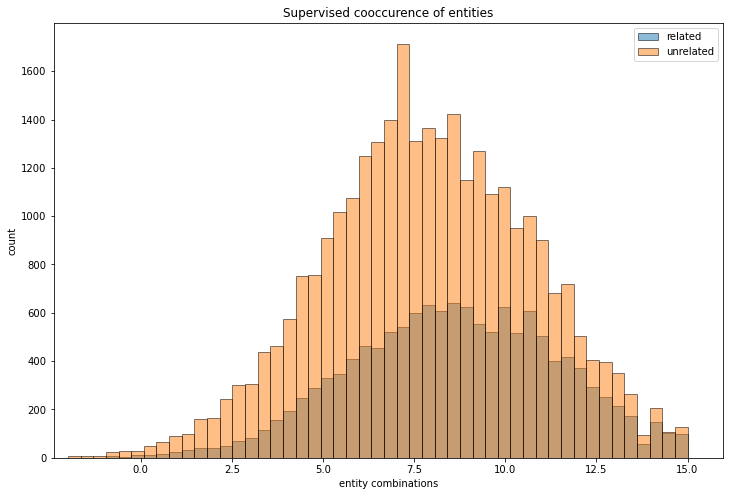

In [31]:
bins = np.linspace(math.ceil(min([min(co_list), min(co_list_false)])), 
                   math.floor(max([max(co_list), max(co_list_false)])),
                   50) # fixed number of bins

fig = plt.figure(figsize=(12, 8))
plt.xlim([min([min(co_list), min(co_list_false)]), max([max(co_list), max(co_list_false)])])

plt.hist(co_list, bins=bins, alpha=0.5, label='related', edgecolor = "black")
plt.hist(co_list_false, bins=bins, alpha=0.5, label='unrelated', edgecolor = "black")
plt.title('Supervised cooccurence of entities')
plt.xlabel('entity combinations')
plt.ylabel('count')
plt.legend()
plt.show()

In [32]:
# prediction
from sklearn.neighbors import KernelDensity
import numpy as np

def predict_kde(kde_rel, kde_un, data):
    score_rel = kde_rel.score_samples(data)
    score_un = kde_un.score_samples(data)
    prediction = score_rel > score_un
    return prediction

related_array = np.array(co_list)
related_array = related_array.reshape(-1, 1)
unrelated_array = np.array(co_list_false)
unrelated_array = unrelated_array.reshape(-1, 1)

kde_rel = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(related_array)
kde_un = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(unrelated_array)
pred_rel = predict_kde(kde_rel, kde_un, related_array)
pred_un = predict_kde(kde_rel, kde_un, unrelated_array)

In [34]:
print(sum(pred_rel) / len(pred_rel))
print(sum(pred_un) / len(pred_un))

0.6305268633424983
0.5221819149998336
